## **Reasoning LLMs using Hugging Face Model**

The below codes were used for experiments using the hugging face model: https://huggingface.co/google/flan-t5-xl

In [1]:
import os

# Setting an environment variable named "HF_TOKEN" to store the Hugging Face API token.
os.environ["HF_TOKEN"] = "<<ADD YOUR TOKEN HERE>>"

In [2]:
# Installing the availability of CUDA environment
import torch
print(torch.cuda.is_available())

True


In [3]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM  # Importing necessary classes for tokenization and model loading
import torch  # Importing PyTorch for device management and tensor operations

# Ensuring the GPU usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Checking if GPU is available and selecting the device (GPU if available, else CPU)

# Loading the Flan-T5 Model (optimized for reasoning tasks)
try:
    model_name = "google/flan-t5-xl"  # Specifying the model name (Flan-T5 XL is a large language model optimized for various NLP tasks)

    # Loading the tokenizer for the specified model (tokenizer converts text to tokens for the model)
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Loading the model for sequence-to-sequence tasks (like translation, summarization, etc.)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)  # Moving the model to the chosen device (GPU or CPU)

    print("Model and tokenizer loaded successfully.")  # Confirmation message if the model and tokenizer are loaded correctly

except Exception as e:
    print(f"Error loading model/tokenizer: {e}")  # Catching and displaying any errors that occur during loading

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.44k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/53.0k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.45G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Model and tokenizer loaded successfully.


**Prompt Generation**

In [4]:
def generate_response(prompt, max_length=512):
    """
    Generates structured and detailed responses from the model.
    :param prompt: The input prompt for the model.
    :param max_length: Maximum token length for the output (default is 512 tokens).
    :return: Decoded model output as a string.
    """
    try:
        # Tokenizing the input prompt and converting it into tensors for PyTorch
        inputs = tokenizer(prompt, return_tensors="pt").to(device)  # Moving tokenized input to the selected device (GPU or CPU)

        # Generating model output by passing the input ids through the model
        # The `do_sample=True` allows for sampling to generate more creative responses
        # `temperature=0.7` controls the randomness of the sampling (lower values make the output more deterministic)
        outputs = model.generate(inputs.input_ids, max_length=max_length, do_sample=True, temperature=0.7)

        # Decoding the generated tokens back into a human-readable string, skipping special tokens like <pad> or <eos>
        return tokenizer.decode(outputs[0], skip_special_tokens=True)

    except Exception as e:
        # If an error occurs, return a descriptive error message
        return f"Error generating response: {e}"

**Experimenting with RAP Agent:**

In [5]:
class RAPAgent:
    def __init__(self, model, tokenizer):
        """
        Initializes the RAPAgent with a model and tokenizer.
        :param model: The language model used for generating responses.
        :param tokenizer: The tokenizer used for encoding/decoding inputs and outputs.
        """
        self.model = model  # Storing the model
        self.tokenizer = tokenizer  # Storing the tokenizer

    def blocksworld(self, initial_state, goal):
        """
        Solves a Blocksworld problem by generating a step-by-step plan.
        :param initial_state: The initial configuration of blocks.
        :param goal: The desired configuration of blocks.
        :return: A string with the generated plan to solve the Blocksworld problem.
        """
        prompt = f"""
        [BLOCKSWORLD]
        You are an expert planner tasked with solving Blocksworld problems step-by-step.
        Here are the allowed actions:
        - Pick up a block.
        - Unstack a block from on top of another block.
        - Put down a block.
        - Stack a block on top of another block.

        Initial State: {initial_state}  # The starting configuration of blocks.
        Goal: {goal}  # The target configuration.

        [PLAN]
        Write the actions step-by-step, and validate each action. If an action is invalid, explain why it fails.

        Example:
        Step 1: Pick up the blue block.
        Step 2: Stack the blue block on the orange block.
        [PLANEND]
        """
        return generate_response(prompt)  # Generating the plan based on the prompt

    def math_reasoning(self, problem):
        """
        Solves a math problem by breaking it down into steps.
        :param problem: The math problem to solve.
        :return: A string with the step-by-step solution.
        """
        prompt = f"""
        [MATH]
        Solve the given math problem step-by-step by breaking it into sub-questions.
        Example:
        Question: John has 50 candies. He gives 20 away. How many are left?
        Step 1: Subtract 20 from 50. The answer is 30.

        Problem: {problem}  # The math problem to be solved.
        Provide detailed steps and verify the calculations.
        """
        return generate_response(prompt)  # Generating the solution to the math problem

    def logical_reasoning(self, facts, rules, hypothesis):
        """
        Analyzes a logical reasoning problem based on facts, rules, and a hypothesis.
        :param facts: A list of known facts.
        :param rules: A list of rules to apply.
        :param hypothesis: The hypothesis to be analyzed.
        :return: A string with the step-by-step logical analysis.
        """
        prompt = f"""
        [LOGICAL-REASONING]
        Use the following facts and rules to analyze the hypothesis step-by-step.
        Facts: {facts}  # The known facts.
        Rules: {rules}  # The rules to apply.
        Hypothesis: {hypothesis}  # The hypothesis to validate.

        [ANALYSIS]
        Step 1: Identify the facts relevant to the hypothesis.
        Step 2: Use the rules to validate the hypothesis.
        Step 3: Conclude whether the hypothesis is [TRUE] or [FALSE].
        """
        return generate_response(prompt)  # Generating the logical analysis based on the given information

**Experimenting with CoT:**

In [6]:
class CoTAgent:
    def __init__(self, model, tokenizer):
        """
        Initializes the CoTAgent with a model and tokenizer.
        :param model: The language model used for generating responses.
        :param tokenizer: The tokenizer used for encoding/decoding inputs and outputs.
        """
        self.model = model  # Storing the model
        self.tokenizer = tokenizer  # Storing the tokenizer

    def blocksworld(self, initial_state, goal):
        """
        Solves a Blocksworld problem step-by-step.
        :param initial_state: The starting configuration of blocks.
        :param goal: The target configuration of blocks.
        :return: A string with the step-by-step solution to the Blocksworld problem.
        """
        prompt = f"""
        [STEP-BY-STEP]
        Solve the Blocksworld problem step-by-step.
        Initial State: {initial_state}  # The current block configuration.
        Goal: {goal}  # The target block configuration.

        Write each action as Step 1, Step 2, etc., and validate each step.

        Example:
        Step 1: Pick up the red block.
        Step 2: Stack the red block on the blue block.
        """
        return generate_response(prompt)  # Generating the step-by-step solution using the model

    def math_reasoning(self, problem):
        """
        Solves a math problem step-by-step by breaking it down into logical steps.
        :param problem: The math problem to solve.
        :return: A string with the step-by-step solution to the math problem.
        """
        prompt = f"""
        [MATH-REASONING]
        Solve this math problem step-by-step.
        Problem: {problem}  # The math problem to solve.

        Provide the steps as Step 1, Step 2, ..., and explain each step clearly.
        """
        return generate_response(prompt)  # Generating the detailed solution with reasoning

    def logical_reasoning(self, facts, rules, hypothesis):
        """
        Analyzes a logical reasoning problem based on facts, rules, and a hypothesis.
        :param facts: The known facts for reasoning.
        :param rules: The rules to apply during reasoning.
        :param hypothesis: The hypothesis to validate.
        :return: A string with the step-by-step logical analysis.
        """
        prompt = f"""
        [LOGICAL-REASONING]
        Break down the hypothesis validation into clear logical steps.
        Facts: {facts}  # The facts that are known.
        Rules: {rules}  # The rules to be applied.
        Hypothesis: {hypothesis}  # The hypothesis to analyze.

        Format:
        Step 1: ...
        Step 2: ...
        Conclude with [TRUE/FALSE].
        """
        return generate_response(prompt)  # Generating the logical analysis based on the input facts and rules

In [15]:
# Defining test cases for the Blocksworld problem.
# Each tuple represents a case with (initial_state, goal).
blocksworld_cases = [
    ("The blue block is on the green block, and the red block is on the table.", "The blue block should be on the red block."),
    ("The yellow block is on the table, and the green block is on the yellow block.", "The green block should be on the red block."),
]

# Defining test cases for math reasoning problems.
# Each tuple represents a problem with (problem_statement, expected_answer).
math_problems = [
    ("If a car travels 60 miles in 2 hours, what is the average speed?", "30 mph"),
    ("A train covers 120 miles in 3 hours. What is the average speed?", "40 mph")
]

# Defining test cases for logical reasoning problems.
# Each tuple represents a case with (facts, rules, hypothesis).
logical_cases = [
    ("All fish live in water. Salmon is a fish.", "All creatures that live in water can swim.", "Salmon can swim."),
    ("All humans need oxygen. Lisa is a human.", "All beings that need oxygen breathe air.", "Lisa breathes air.")
]

In [16]:
# Evaluating RAP and CoT
agents = {'RAP': RAPAgent(model, tokenizer), 'CoT': CoTAgent(model, tokenizer)}
results = {'RAP': [], 'CoT': []}

for agent_name, agent in agents.items():
    print(f"\nEvaluating {agent_name} Agent...\n")

    # Blocksworld Evaluation
    for initial_state, goal in blocksworld_cases:
        response = agent.blocksworld(initial_state, goal)
        print(f"{agent_name} Blocksworld Plan:\n{response}\n")
        results[agent_name].append(1)  # Placeholder for evaluation logic

    # Math Reasoning Evaluation
    for problem, expected in math_problems:
        response = agent.math_reasoning(problem)
        print(f"{agent_name} Math Solution:\n{response}\n")
        results[agent_name].append(response.strip().endswith(expected))

    # Logical Reasoning Evaluation
    for facts, rules, hypothesis in logical_cases:
        response = agent.logical_reasoning(facts, rules, hypothesis)
        print(f"{agent_name} Logical Reasoning:\n{response}\n")
        results[agent_name].append("true" in response.lower() or "false" in response.lower())


Evaluating RAP Agent...

RAP Blocksworld Plan:
Step 1: Pick up the blue block. Step 2: Stack the blue block on the orange block.

RAP Blocksworld Plan:
Step 1: Pick up the blue block. Step 2: Stack the blue block on the orange block.

RAP Math Solution:
If a car travels 60 miles in 2 hours, then it has traveled 60 / 2 = 30 miles per hour. The average speed must be 30 / 2 = 15. The answer is 15.

RAP Math Solution:
The train travels 120 miles / 3 hours = 40 miles / hour. The average speed is 40 miles / 3 hours = 20 miles / hour. The answer: 20.

RAP Logical Reasoning:
Fact1: Salmon live in water. Fact2: All creatures that live in water can swim. Fact3: This is true.

RAP Logical Reasoning:
Fact1: Lisa is a human and all humans need oxygen. Fact2: All beings that need oxygen breathe air. Fact3: Lisa breathes air.


Evaluating CoT Agent...

CoT Blocksworld Plan:
Step 1: Pick up the red block. Step 2: Stack the red block on the blue block.

CoT Blocksworld Plan:
Step 1: Pick up the red bl

In [17]:
# Defining the initial state and goal for the Blocksworld problem
initial_state = "The blue block is on the green block, and the red block is on the table."
goal = "The blue block should be on the red block."

# Printing the results of solving the Blocksworld problem using both CoTAgent and RAPAgent
# The CoTAgent and RAPAgent are expected to generate different responses based on their reasoning approaches
print("CoT Blocksworld:", CoTAgent(model, tokenizer).blocksworld(initial_state, goal))
print("RAP Blocksworld:", RAPAgent(model, tokenizer).blocksworld(initial_state, goal))

# Defining a math reasoning problem to calculate the average speed of a car
problem = "If a car travels 60 miles in 2 hours, what is the average speed?"

# Printing the results of solving the math reasoning problem using both CoTAgent and RAPAgent
# Both agents will generate the step-by-step solution but may vary in how they break down the problem
print("CoT Math Reasoning:", CoTAgent(model, tokenizer).math_reasoning(problem))
print("RAP Math Reasoning:", RAPAgent(model, tokenizer).math_reasoning(problem))

# Defining logical reasoning facts, rules, and hypothesis for validation
facts = "All fish live in water. Salmon is a fish."
rules = "All creatures that live in water can swim."
hypothesis = "Salmon can swim."

# Printing the results of logical reasoning based on the provided facts, rules, and hypothesis
# CoTAgent and RAPAgent will analyze the hypothesis and provide step-by-step logical reasoning
print("CoT Logical Reasoning:", CoTAgent(model, tokenizer).logical_reasoning(facts, rules, hypothesis))
print("RAP Logical Reasoning:", RAPAgent(model, tokenizer).logical_reasoning(facts, rules, hypothesis))

CoT Blocksworld: Step 1: Pick up the red block. Step 2: Stack the red block on the blue block.
RAP Blocksworld: Step 1: Pick up the blue block. Step 2: Stack the blue block on the orange block.
CoT Math Reasoning: Step 1: 60 miles = 60 * 2 = 120. The average speed is 120 / 2 = 60 miles per hour. Step 2: 60 miles = 60 / 2 = 30 miles per hour. The average speed is 30 / 60 = 5 miles per hour.
RAP Math Reasoning: The total distance travelled is 60 miles / 2 hours = 30 miles. The average speed is 30 miles / 2 hours = 15 miles / hour. The answer is 15.
CoT Logical Reasoning: Step 1: Salmon are fish. Step 2: All creatures that live in water can swim. Step 3: Salmon can swim.
RAP Logical Reasoning: It is logical to assume that a salmon can swim as it lives in water.


In [18]:
# Ground truths: A list of truth values (1 represents the correct answer, 0 represents an incorrect answer)
# The list is constructed by repeating [1, 1] for each case in different problem types: Blocksworld, Math, and Logical reasoning.

# Creating a ground truth list for each case in Blocksworld, Math, and Logical reasoning problems
truths = [1, 1] * len(blocksworld_cases) + [1, 1] * len(math_problems) + [1, 1] * len(logical_cases)

# Explanation:
# - [1, 1] represents the ground truth for two cases, where the truth values are '1' for correct answers.
# - len(blocksworld_cases), len(math_problems), and len(logical_cases) are the counts of cases in each category.
# - By multiplying [1, 1] by the length of each case list, we generate a list of correct truth values for each corresponding problem.
# - The final list, 'truths', contains the ground truth labels for all cases from the Blocksworld, Math, and Logical reasoning tasks.

**Evaluating the Agents Performances**

In [19]:
# Required imports for evaluating classification performance metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Correcting the truths list to ensure it has the correct length.
# Each problem in Blocksworld, Math, and Logical reasoning is expected to have a ground truth of 1 (correct answer).
truths = [1] * (len(blocksworld_cases) + len(math_problems) + len(logical_cases))

# Task-wise breakdown of results: organize the results by agent and task type
task_names = ['Blocksworld', 'Math Reasoning', 'Logical Reasoning']  # Names for the tasks
results_by_task = {
    'RAP': {  # Results for the RAP agent
        'Blocksworld': results['RAP'][:len(blocksworld_cases)],  # First part of the results corresponding to Blocksworld
        'Math Reasoning': results['RAP'][len(blocksworld_cases):len(blocksworld_cases) + len(math_problems)],  # Next part for Math Reasoning
        'Logical Reasoning': results['RAP'][-len(logical_cases):],  # Last part for Logical Reasoning
    },
    'CoT': {  # Results for the CoT agent
        'Blocksworld': results['CoT'][:len(blocksworld_cases)],  # First part of the results corresponding to Blocksworld
        'Math Reasoning': results['CoT'][len(blocksworld_cases):len(blocksworld_cases) + len(math_problems)],  # Next part for Math Reasoning
        'Logical Reasoning': results['CoT'][-len(logical_cases):],  # Last part for Logical Reasoning
    }
}

# Calculating performance metrics for each agent and task
metrics = {}

# Loop through each agent (RAP and CoT) and each task to calculate metrics
for agent_name, tasks in results_by_task.items():
    metrics[agent_name] = {}  # Initialize a dictionary to store metrics for the agent

    # Loop through each task (Blocksworld, Math Reasoning, Logical Reasoning)
    for task_name, predictions in tasks.items():
        # For each task, compute the accuracy, precision, recall, and F1 score
        metrics[agent_name][task_name] = {
            "Accuracy": accuracy_score(truths[:len(predictions)], predictions),  # Accuracy metric
            "Precision": precision_score(truths[:len(predictions)], predictions, zero_division=1),  # Precision metric, handling zero division
            "Recall": recall_score(truths[:len(predictions)], predictions),  # Recall metric
            "F1 Score": f1_score(truths[:len(predictions)], predictions)  # F1 score metric
        }

# Printing the calculated metrics for each agent and task
for agent_name, task_metrics in metrics.items():
    print(f"\n{agent_name} Metrics:")  # Print the agent name

    # Loop through each task's metrics and print the results
    for task_name, metric_values in task_metrics.items():
        print(f"\n{task_name}:")  # Print the task name
        for metric_name, value in metric_values.items():
            # Print the value of each metric rounded to two decimal places
            print(f"{metric_name}: {value:.2f}")


RAP Metrics:

Blocksworld:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00

Math Reasoning:
Accuracy: 0.00
Precision: 1.00
Recall: 0.00
F1 Score: 0.00

Logical Reasoning:
Accuracy: 0.50
Precision: 1.00
Recall: 0.50
F1 Score: 0.67

CoT Metrics:

Blocksworld:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00

Math Reasoning:
Accuracy: 0.00
Precision: 1.00
Recall: 0.00
F1 Score: 0.00

Logical Reasoning:
Accuracy: 0.00
Precision: 1.00
Recall: 0.00
F1 Score: 0.00


**Visualizations**

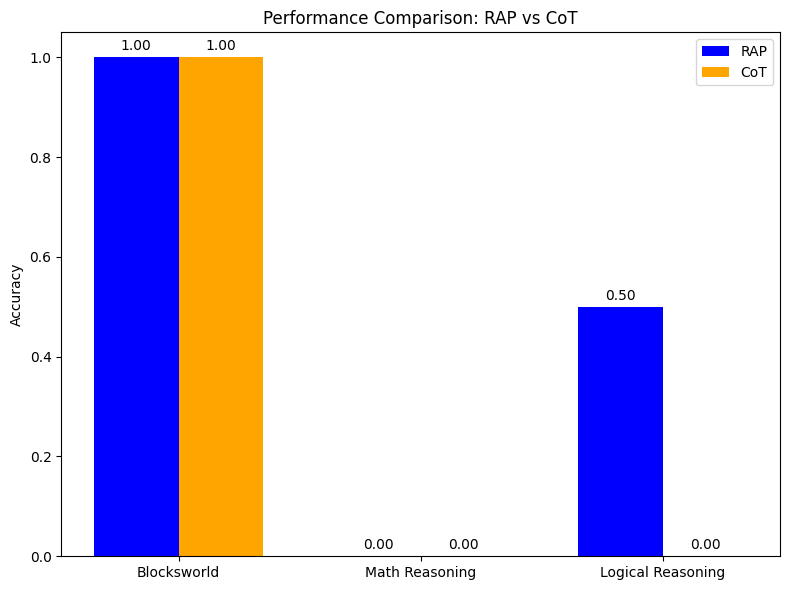

In [20]:
# Importing necessary libraries for plotting and numerical operations
import matplotlib.pyplot as plt
import numpy as np

# Task Labels: These are the categories or tasks for comparison (Blocksworld, Math Reasoning, Logical Reasoning)
labels = ['Blocksworld', 'Math Reasoning', 'Logical Reasoning']

# Separate task-wise scores for RAP and CoT:
# Calculate the average score for each task (Blocksworld, Math Reasoning, Logical Reasoning) for RAP
rap_blocksworld = sum(results['RAP'][:len(blocksworld_cases)]) / len(blocksworld_cases)
rap_math = sum(results['RAP'][len(blocksworld_cases):len(blocksworld_cases) + len(math_problems)]) / len(math_problems)
rap_logical = sum(results['RAP'][-len(logical_cases):]) / len(logical_cases)

# Calculate the average score for each task (Blocksworld, Math Reasoning, Logical Reasoning) for CoT
cot_blocksworld = sum(results['CoT'][:len(blocksworld_cases)]) / len(blocksworld_cases)
cot_math = sum(results['CoT'][len(blocksworld_cases):len(blocksworld_cases) + len(math_problems)]) / len(math_problems)
cot_logical = sum(results['CoT'][-len(logical_cases):]) / len(logical_cases)

# Combine the task-wise scores into separate lists for RAP and CoT
rap_scores = [rap_blocksworld, rap_math, rap_logical]  # RAP agent's average scores for each task
cot_scores = [cot_blocksworld, cot_math, cot_logical]  # CoT agent's average scores for each task

# Plotting:
# Set the x-axis positions for each bar group
x = np.arange(len(labels))  # X-axis positions based on the number of labels (tasks)
width = 0.35  # Width of the bars for the bar chart

# Create a figure and axis object for the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the bars for RAP and CoT scores
bars1 = ax.bar(x - width / 2, rap_scores, width, label='RAP', color='blue')  # RAP scores in blue
bars2 = ax.bar(x + width / 2, cot_scores, width, label='CoT', color='orange')  # CoT scores in orange

# Adding labels and title to the plot
ax.set_xticks(x)  # Set the x-axis ticks at the positions of the tasks
ax.set_xticklabels(labels)  # Set the x-axis labels (tasks)
ax.set_ylabel("Accuracy")  # Label for the y-axis
ax.set_title("Performance Comparison: RAP vs CoT")  # Title for the plot
ax.legend()  # Display the legend for the bars (RAP and CoT)

# Function to display scores above each bar
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()  # Get the height of each bar (score)
        ax.annotate(f'{height:.2f}',  # Display the score value rounded to 2 decimal places
                    xy=(bar.get_x() + bar.get_width() / 2, height),  # Position the annotation above the bar
                    xytext=(0, 3),  # Offset the annotation slightly above the bar
                    textcoords="offset points",  # Use offset points for positioning
                    ha='center', va='bottom')  # Align the annotation horizontally and vertically

# Add score labels above the RAP and CoT bars
add_labels(bars1)
add_labels(bars2)

# Adjust the layout to ensure everything fits and displays properly
plt.tight_layout()

# Show the plot
plt.show()